In [31]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout

In [2]:
end = date.today()
start = date(end.year - 20, end.month, end.day)
stock_symbol = 'GOOG'
data = yf.download(stock_symbol, start, end)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.reset_index(inplace=True)


In [4]:
ma_100_days = data['Close'].ewm(span=100, adjust=False).mean()
ma_200_days = data['Close'].ewm(span=200, adjust=False).mean()

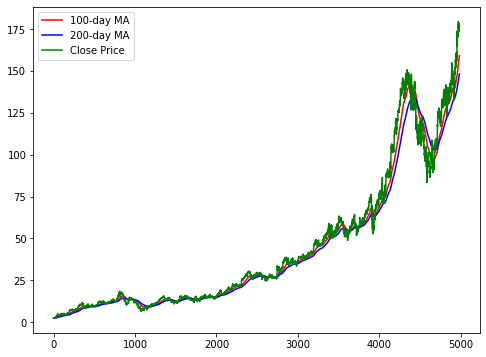

In [5]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r', label='100-day MA')
plt.plot(ma_200_days, 'b', label='200-day MA')
plt.plot(data.Close, 'g', label='Close Price')
plt.legend()
plt.show()

In [6]:
data.dropna(inplace=True)


In [7]:
data_train = pd.DataFrame(data.Close[0: int(len(data)* 0.8)])
data_test = pd.DataFrame(data.Close[int(len(data) * 0.80): len(data)])

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scale = scaler.fit_transform(data_train)

In [9]:
# Create sequences for CNN
x = []
y = []
for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i, 0])
    y.append(data_train_scale[i, 0])
x, y = np.array(x), np.array(y)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

In [32]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x.shape[1], 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', dilation_rate=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', dilation_rate=4))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', dilation_rate=8))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1))

In [33]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
model.fit(x, y, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
122/122 [==============================] - 7s 29ms/step - loss: 0.0036
Epoch 2/50
122/122 [==============================] - 3s 24ms/step - loss: 0.0011
Epoch 3/50
122/122 [==============================] - 3s 23ms/step - loss: 6.8922e-04
Epoch 4/50
122/122 [==============================] - 3s 21ms/step - loss: 7.1432e-04
Epoch 5/50
122/122 [==============================] - 2s 16ms/step - loss: 5.1652e-04
Epoch 6/50
122/122 [==============================] - 2s 20ms/step - loss: 4.3031e-04
Epoch 7/50
122/122 [==============================] - 2s 17ms/step - loss: 3.2932e-04
Epoch 8/50
122/122 [==============================] - 3s 22ms/step - loss: 3.5608e-04
Epoch 9/50
122/122 [==============================] - 2s 16ms/step - loss: 2.8203e-04
Epoch 10/50
122/122 [==============================] - 2s 18ms/step - loss: 2.7887e-04
Epoch 11/50
122/122 [==============================] - 2s 19ms/step - loss: 2.1083e-04
Epoch 12/50
122/122 [==============================] - 2s 19

In [35]:
past_100_days = data_train.tail(100)
data_test = pd.concat([past_100_days, data_test], ignore_index=True)
data_test_scale = scaler.transform(data_test)

In [36]:
x_test = []
y_test = []
for i in range(100, data_test_scale.shape[0]):
    x_test.append(data_test_scale[i-100:i, 0])
    y_test.append(data_test_scale[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [37]:
y_pred = model.predict(x_test)


38/38 [==============================] - 8s 9ms/step


In [38]:
y_pred = scaler.inverse_transform(y_pred)


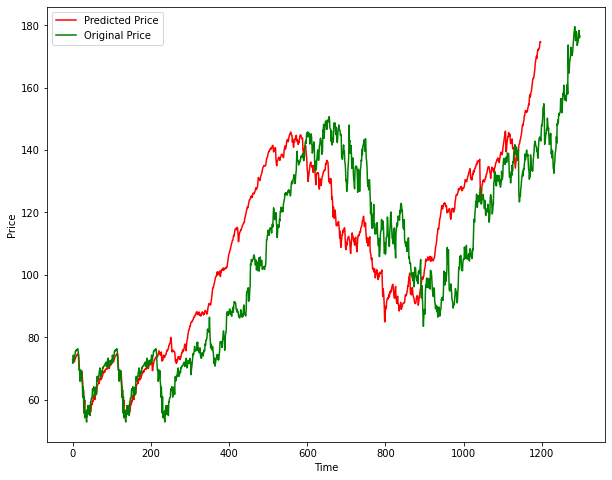

In [39]:
plt.figure(figsize=(10, 8))
plt.plot(y_pred, 'r', label='Predicted Price')
plt.plot(data_test['Close'].values, 'g', label='Original Price')
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [40]:
model.save("TCN_Stock_Prediction_Model.keras")

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 98, 64)            256       
                                                                 
 conv1d_5 (Conv1D)           (None, 94, 64)            12352     
                                                                 
 conv1d_6 (Conv1D)           (None, 86, 64)            12352     
                                                                 
 conv1d_7 (Conv1D)           (None, 70, 64)            12352     
                                                                 
 flatten_2 (Flatten)         (None, 4480)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                286784    
                                                                 
 dense_5 (Dense)             (None, 1)                